<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Deliverable 📬

To complete this project, your team should: 

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [8]:
#!pip install wordcloud

  Using cached wordcloud-1.9.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (539 kB)


In [9]:
import pandas as pd
import numpy as np 
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
#import tensorflow_datasets as tfds
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
import wordcloud

import json
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import GRU, Dropout, BatchNormalization

# Data Preprocessing

## Load and clean Dataset

In [2]:
dataset = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv', encoding='latin-1')#'windows-1252')
print(dataset.shape)
dataset.head()

(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
dataset.describe()

# dataset avec une imbalanced target (v1)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [12]:
# Check for missing values
print("\nMissing values:\n")
print(dataset.isnull().sum())


Missing values:

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [3]:
# 30 répétitions sur la colonne v2 qui risquent de biaiser les modèles sur cette phrase -> drop des 29 colonnes en trop

list_drop = dataset[dataset['v2'] == "Sorry, I'll call later"].index
print(list_drop)
dataset = dataset.drop(list_drop[1:], axis=0).reset_index(drop=True)
dataset.shape

Index([  80,  222,  338,  443,  701,  767, 1131, 1151, 1484, 1584, 1901, 1980,
       1988, 2384, 2446, 2517, 2521, 2523, 2645, 3347, 3364, 3532, 3592, 4126,
       4171, 4189, 5191, 5423, 5458, 5558],
      dtype='int64')


(5543, 5)

In [18]:
# étude des colonnes 3 à 5 : faut-il les garder ?

dataset[pd.notna(dataset["Unnamed: 2"])].head(10)

# conclusion : quand les colonnes 3,4,5 sont non-NaN, il semble que c'est la suite du message de v2 -> à concaténer avec la v2 lorsque non-Nan

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
280,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
441,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
668,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
706,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
894,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1033,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1122,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1259,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1377,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In [4]:
dataset[dataset.isnull() == True] = ''
dataset['concat'] = dataset['v2'] + dataset['Unnamed: 2'] + dataset['Unnamed: 3'] + dataset['Unnamed: 4']

# verification de la concaténation :
dataset.iloc[280,:]

v1                                                          ham
v2                                          \Wen u miss someone
Unnamed: 2     the person is definitely special for u..... B...
Unnamed: 3                                     why to miss them
Unnamed: 4                        just Keep-in-touch\" gdeve.."
concat        \Wen u miss someone the person is definitely s...
Name: 280, dtype: object

## Data Exploration

In [5]:
data = dataset.loc[:,["v1", "concat"]]
data.columns = ["class", "text"]
data.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
# vérification des missing values
print("\nMissing values:\n")
print(data.isnull().sum())


Missing values:

class    0
text     0
dtype: int64


In [22]:
# vérification du déséquilibre de classes
data['class'].value_counts()

class
ham     4796
spam     747
Name: count, dtype: int64

In [6]:
# tailles des messages pour ham et spam 

data["text_length"] = data["text"].apply(len)

fig = px.histogram(data, "text_length", color="class", barmode="overlay")
fig.show()

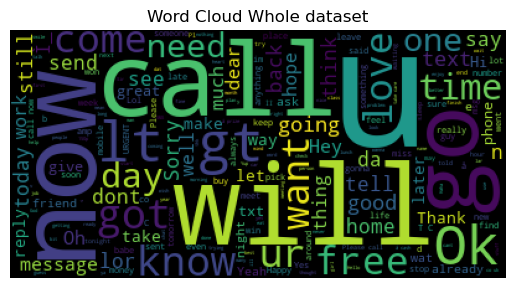

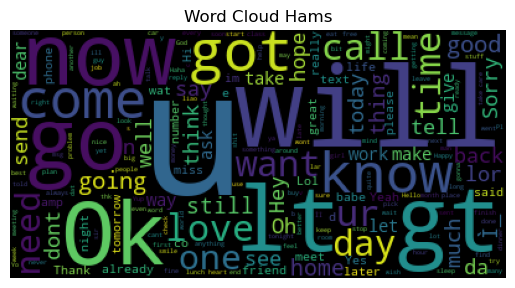

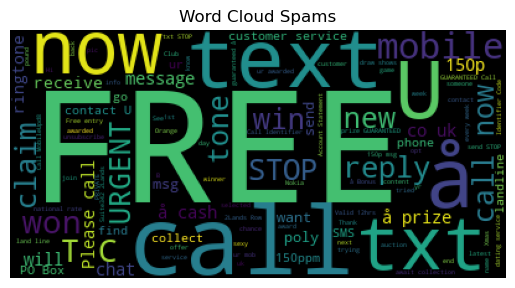

In [21]:
# wordclouds pour ham et spam

wd = wordcloud.WordCloud()
cloud = wd.generate(' '.join(data['text']))
wd = wordcloud.WordCloud()
cloud_ham = wd.generate(' '.join(data.loc[data["class"] == "ham","text"]))
wd = wordcloud.WordCloud()
cloud_spam = wd.generate(' '.join(data.loc[data["class"] == "spam","text"]))

plt.imshow(cloud)
plt.title('Word Cloud Whole dataset')
plt.axis("off")
plt.show()

plt.imshow(cloud_ham)
plt.title('Word Cloud Hams')
plt.axis("off")
plt.show()

plt.imshow(cloud_spam)
plt.title('Word Cloud Spams')
plt.axis("off")
plt.show()

# conclusion : il y a des mots-clefs qui sont reliés aux spams, c'est pour cela que l'Embedding simple fonctionne mieux que les modèles RNN

## Preprocessing

In [14]:
#!python -m spacy download en_core_web_md #en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 11.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [23]:
import en_core_web_md
nlp = en_core_web_md.load()

from spacy.lang.en.stop_words import STOP_WORDS

In [24]:
data['text_clean'] = data['text'].apply(lambda x: ''.join(ch for ch in x if ch.isalnum() or ch==" "))
data['text_clean'] = data['text_clean'].apply(lambda x: x.replace('  ', ' ').lower().strip())
data['text_clean'] = data['text_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
data['text_clean'] = data['text_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

data.head()

,class,text,text_length,text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live


In [25]:
mask1 = data.text_clean.apply(lambda x: type(x)==str)
print('texts as str in data :\n', mask1.value_counts())

mask2 = data.text_clean.isna()==True
print('texts as NaN in data :\n', mask2.value_counts())

texts as str in data :
 text_clean
True    5543
Name: count, dtype: int64
texts as NaN in data :
 text_clean
False    5543
Name: count, dtype: int64


In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(data.text_clean)
data["text_encoded"] = tokenizer.texts_to_sequences(data.text_clean)

data["len_txt"] = data["text_encoded"].apply(lambda x: len(x))
data = data[data["len_txt"]!=0]

data.head()

,class,text,text_length,text_clean,text_encoded,len_txt
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[235, 445, 464, 942, 34, 51, 207, 943, 79, 944...",11
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[9, 195, 465, 289, 1]",5
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 299, 3, 533, 663, 31, 852, 424, 19, 154, ...",13
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[1, 125, 150, 1, 85]",5
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[714, 21, 664, 126]",4


In [27]:
data.shape 

# Avec le preprocessing, on a retiré au total 186 lignes 

(5386, 6)

In [29]:
print(len(tokenizer.index_word.keys()))
#tokenizer.index_word

# Des caractères spéciaux sont présents, mais ils peuvent avoir un lien avec les spams -> je ne change rien

8236


In [39]:
vocab_size = len(tokenizer.index_word.keys()) 
print(vocab_size)

8236


In [30]:
texts_pad = tf.keras.preprocessing.sequence.pad_sequences(data.text_encoded, padding="post")
texts_pad.shape

# Ce sont de très courts messages : probablement des SMS

(5386, 47)

In [31]:
data['cat'] = data['class'].apply(lambda x: 1 if x == 'spam' else 0)
data.head()

/tmp/ipykernel_6126/1981104026.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,class,text,text_length,text_clean,text_encoded,len_txt,cat
0,ham,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[235, 445, 464, 942, 34, 51, 207, 943, 79, 944...",11,0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[9, 195, 465, 289, 1]",5,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 299, 3, 533, 663, 31, 852, 424, 19, 154, ...",13,1
3,ham,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[1, 125, 150, 1, 85]",5,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[714, 21, 664, 126]",4,0


In [33]:
X_temp, X_test, y_temp, y_test = train_test_split(texts_pad, data.cat, test_size=0.1, random_state=42, stratify=data.cat)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
train_batch = train_ds.shuffle(len(train_ds)).batch(BATCH_SIZE)
val_batch = val_ds.batch(BATCH_SIZE)

In [34]:
display(y_train.value_counts())
display(y_val.value_counts())
y_test.value_counts()

cat
0    3341
1     536
Name: count, dtype: int64

cat
0    836
1    134
Name: count, dtype: int64

cat
0    464
1     75
Name: count, dtype: int64

In [35]:
# vérification du contenu d'un batch :

for text_batch, label_batch in train_batch.take(1):
    print(label_batch, text_batch)

tf.Tensor([0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0], shape=(32,), dtype=int64) tf.Tensor(
[[ 27 341 621 ...   0   0   0]
 [  5   1   0 ...   0   0   0]
 [613 121  15 ...   0   0   0]
 ...
 [ 52   9 452 ...   0   0   0]
 [281 590  16 ...   0   0   0]
 [589 374   0 ...   0   0   0]], shape=(32, 47), dtype=int32)


2025-02-07 18:13:09.187375: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
# création du dictionnaire des weights pour pénaliser les ham dans les modèles

df_vc = data['cat'].value_counts()
display(df_vc)

d_cat = {}
for cat in df_vc.index:
    val = (1/df_vc[cat])*sum(df_vc.values)/2
    d_cat[cat] = val
print(d_cat)

cat
0    4641
1     745
Name: count, dtype: int64

{0: 0.5802628743805214, 1: 3.6147651006711405}

In [37]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [38]:
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True 
)

# Modèle Baseline : Embedding simple

Modèles testés et conclusions :
- 3 couches Dense hidden :
    - couche de prédiction en sigmoid : early stopping à 18 epochs, 3.5 minutes, f1 weighted = 0.98
    - couche de prédiction en softmax : early stopping à 10 epochs, 2 minutes, f1 weighted = 0.98
- 5 couches Dense hidden : 
    - couche de prédiction en sigmoid : early stopping à 16 epochs, 4 minutes, f1 weighted = 0.97
    - couche de prédiction en softmax : early stopping à 15 epochs, 3.5 minutes, f1 weighted = 0.99

Conclusion : je valide le modèle 3 couches Dense hidden en softmax

In [39]:
len_texts = texts_pad.shape[1] #47

embedding_dim=128 
vocab_size = 1000 

model_baseline = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(len_texts, activation='relu'), 
  Dense(80, activation='relu'), 
  Dense(20, activation='relu'), 
  Dense(2, activation="softmax") 
])

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_baseline.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [59]:
history = model_baseline.fit(
    train_batch,
    validation_data=val_batch,
    class_weight=d_cat,
    callbacks=[early_stopping],
    epochs=20)

Epoch 1/20


122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.1417 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.0592 - val_sparse_categorical_accuracy: 0.9845
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.1221 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.0921 - val_sparse_categorical_accuracy: 0.9835
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.0722 - val_sparse_categorical_accuracy: 0.9794
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0784 - val_sparse_categorical_accuracy: 0.9794
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0803 - val_sparse_categorical_accuracy: 0.9773
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.0927 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.2164 - val_sparse_categorical_accuracy: 0.9062


In [124]:
model_baseline.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 159, 128)       │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_14     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 159)            │        20,511 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 80)             │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,305 (1.87 MB)

 Trainable params: 163,101 (637.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 326,204 (1.24 MB)

In [60]:
# Evaluate the Model
predictions = model_baseline.predict(X_test)
y_pred = (predictions > 0.5).astype("int")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

# Modèle Embedding avec régulation

Modèles testés et conclusions :
- DropOut à 20% après chaque Dense hidden :
    - sans BatchNormalization : early stopping à 9 epochs, 2 minutes, f1 weighted = 0.98
    - avec BatchNormalization après le premier Dense : early stopping à 10 epochs, 2.5 minutes, f1 weighted = 0.99
- L1 et L2 : 
    - L2 sur le premier Dense, L1 sur les deux autres : early stopping à 17 epochs, 5 minutes, f1 weighted = 0.98
    - L1 sur le premier Dense, L2 sur les deux autres : 20 epochs, 6 minutes, f1 weighted = 0.99

Conclusion : je valide le modèle DropOut avec BatchNormalization

In [114]:
len_texts = texts_pad.shape[1] #47

embedding_dim=128 
vocab_size = 1000 

model_EmbRegul = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(len_texts, activation='relu'),
  BatchNormalization(),
  Dropout(0.20),
  Dense(80, activation='relu'), 
  Dropout(0.20),
  Dense(20, activation='relu'), 
  Dense(2, activation="softmax") 
])

In [115]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_EmbRegul.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [116]:
history = model_EmbRegul.fit(
    train_batch,
    validation_data=val_batch,
    class_weight=d_cat,
    callbacks=[early_stopping],
    epochs=20)

Epoch 1/20


/home/eugenie_laptop/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - loss: 0.4415 - sparse_categorical_accuracy: 0.8136 - val_loss: 0.2999 - val_sparse_categorical_accuracy: 0.8660
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.3354 - val_sparse_categorical_accuracy: 0.8660
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.1711 - val_sparse_categorical_accuracy: 0.9309
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0723 - val_sparse_categorical_accuracy: 0.9835
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.0763 - val_sparse_categorical_accuracy: 0.9763
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0736 - val_sparse_categorical_accuracy: 0.97

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          ),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          )
])
fig.update_layout(
    title='Embedding avec regulation : Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          ),
                      go.Scatter(
                          y=history.history["val_binary_accuracy"],
                          name="Validation accuracy",
                          mode="lines",
                          )
])
fig.update_layout(
    title='Embedding avec regulation : Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Accuracy'
)
fig.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


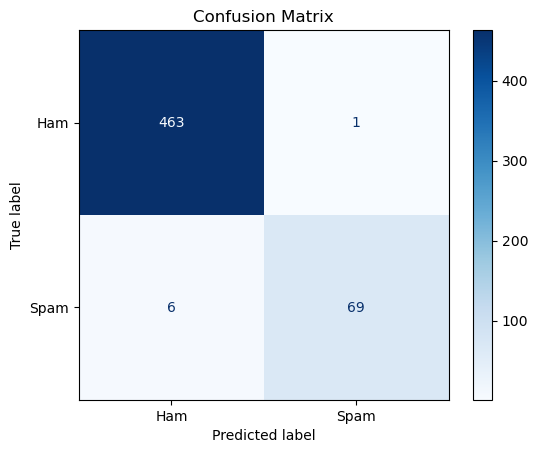

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       464
           1       0.99      0.92      0.95        75

    accuracy                           0.99       539
   macro avg       0.99      0.96      0.97       539
weighted avg       0.99      0.99      0.99       539



In [117]:
# Evaluation du modèle
predictions = model_EmbRegul.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

In [118]:
model_EmbRegul.save("./Projet/Emb_3Dense_DropOut_BatchNorm.keras")

# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
print(type(history_dict))
# Save it under the form of a json file
json.dump(history_dict, open("./Projet/Emb_3Dense_DropOut_BatchNorm.json", 'w'))

<class 'dict'>


# Modèle RNN

Modèles testés et conclusions :
- Simple RNN : early stopping à 9 epochs, 20 secondes, f1 weighted = 0.96
- GRU : 20 epochs, 1.5 minutes, f1 weighted = 0.97
- LSTM : 20 epochs, 17 minutes, f1 weighted = 0.94

Conclusion : les modèles d'Embedding simples ont de meilleures performances

In [ ]:
embedding_dim=128 
vocab_size = 1000 

model_GRU = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"),
  GRU(units=64, return_sequences=False), 
  Dropout(0.20),
  Dense(2, activation="softmax")
])

In [ ]:
model_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 47, 128)        │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,324 (1.89 MB)

 Trainable params: 165,441 (646.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 330,883 (1.26 MB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_GRU.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history = model_GRU.fit(
    train_batch,
    validation_data=val_batch,
    class_weight=d_cat,
    callbacks=[early_stopping],
    epochs=20)

Epoch 1/20


/home/eugenie_laptop/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



122/122 ━━━━━━━━━━━━━━━━━━━━ 88s 714ms/step - loss: 0.6684 - sparse_categorical_accuracy: 0.7367 - val_loss: 0.8211 - val_sparse_categorical_accuracy: 0.1381
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 687ms/step - loss: 0.7041 - sparse_categorical_accuracy: 0.3426 - val_loss: 0.7144 - val_sparse_categorical_accuracy: 0.1381
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 688ms/step - loss: 0.6950 - sparse_categorical_accuracy: 0.3479 - val_loss: 0.7109 - val_sparse_categorical_accuracy: 0.1381
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 691ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.5313 - val_loss: 0.7035 - val_sparse_categorical_accuracy: 0.1381
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 687ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.5761 - val_loss: 0.6910 - val_sparse_categorical_accuracy: 0.8619
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 84s 692ms/step - loss: 0.6828 - sparse_categorical_accuracy: 0.5959 - val_loss: 0.6843 - val_sparse_categorical_accuracy: 0.86

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


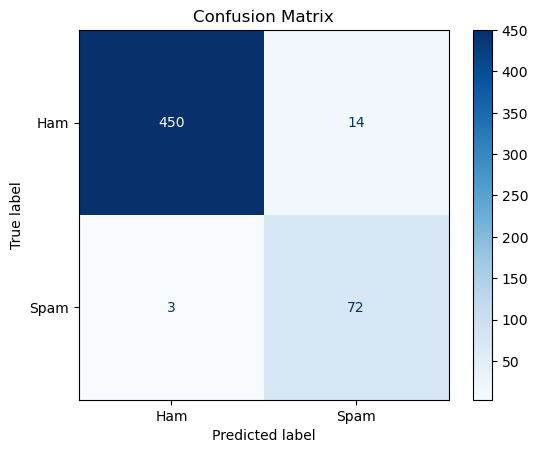

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       464
           1       0.84      0.96      0.89        75

    accuracy                           0.97       539
   macro avg       0.92      0.96      0.94       539
weighted avg       0.97      0.97      0.97       539



In [ ]:
# Evaluation du modèle
predictions = model_GRU.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

# RNN avec data augmentation

In [40]:
dataspams = data.iloc[:,:]
print(dataspams.shape)
index_spam = dataspams[dataspams['class'] == "spam"].index
print(len(index_spam), index_spam)
for index in index_spam:
    for repetition in range(6): # chaque spam va apparaître 7 fois
        dataspams = pd.concat([dataspams, data.loc[[index]]], ignore_index=True)
print(dataspams.shape)
dataspams.tail()

(5386, 7)
745 Index([   2,    5,    8,    9,   11,   12,   15,   19,   34,   42,
       ...
       5464, 5469, 5473, 5496, 5498, 5509, 5512, 5519, 5537, 5538],
      dtype='int64', length=745)
(9856, 7)


,class,text,text_length,text_clean,text_encoded,len_txt,cat
9851,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[267, 17, 48, 3, 92, 1, 1, 31, 279, 69, 3, 49,...",16,1
9852,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[267, 17, 48, 3, 92, 1, 1, 31, 279, 69, 3, 49,...",16,1
9853,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[267, 17, 48, 3, 92, 1, 1, 31, 279, 69, 3, 49,...",16,1
9854,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[267, 17, 48, 3, 92, 1, 1, 31, 279, 69, 3, 49,...",16,1
9855,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time try 2 contact u u win å750 pound priz...,"[267, 17, 48, 3, 92, 1, 1, 31, 279, 69, 3, 49,...",16,1


In [41]:
texts_pad_spams = tf.keras.preprocessing.sequence.pad_sequences(dataspams.text_encoded, padding="post")
print(texts_pad_spams.shape)

BATCH_SIZE = 32

from sklearn.model_selection import train_test_split
X_temp, X_test_spams, y_temp, y_test_spams = train_test_split(texts_pad_spams, dataspams.cat, test_size=0.1, random_state=42, stratify=dataspams.cat)
X_train_spams, X_val_spams, y_train_spams, y_val_spams = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)
train_ds_spams = tf.data.Dataset.from_tensor_slices((X_train_spams, y_train_spams))
val_ds_spams = tf.data.Dataset.from_tensor_slices((X_val_spams, y_val_spams))
train_batch_spams = train_ds_spams.shuffle(len(train_ds_spams)).batch(BATCH_SIZE)
val_batch_spams = val_ds_spams.shuffle(len(val_ds_spams)).batch(BATCH_SIZE)

display(y_train_spams.value_counts())
display(y_val_spams.value_counts())
y_test_spams.value_counts()

(9856, 47)


cat
1    3754
0    3342
Name: count, dtype: int64

cat
1    939
0    835
Name: count, dtype: int64

cat
1    522
0    464
Name: count, dtype: int64

In [42]:
embedding_dim=128 
vocab_size = 1000 

model_GRU_dataaugm = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"),
  GRU(units=64, return_sequences=False), 
  Dropout(0.20),
  Dense(2, activation="softmax")
])

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_GRU_dataaugm.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [47]:
history = model_GRU_dataaugm.fit(
    train_batch_spams,
    validation_data=val_batch_spams,
    epochs=20)

Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 123s 553ms/step - loss: 0.6904 - sparse_categorical_accuracy: 0.5376 - val_loss: 0.6915 - val_sparse_categorical_accuracy: 0.5293
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 116s 525ms/step - loss: 0.6917 - sparse_categorical_accuracy: 0.5333 - val_loss: 0.6914 - val_sparse_categorical_accuracy: 0.5293
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 117s 526ms/step - loss: 0.6908 - sparse_categorical_accuracy: 0.5376 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.5293
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 117s 527ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.5119 - val_loss: 0.6918 - val_sparse_categorical_accuracy: 0.5293
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 117s 528ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.5162 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.5293
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 117s 528ms/step - loss: 0.6862 - sparse_categorical_accuracy: 0.5526 - val_loss: 0.6945 - val_sparse_categoric

/home/eugenie_laptop/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step


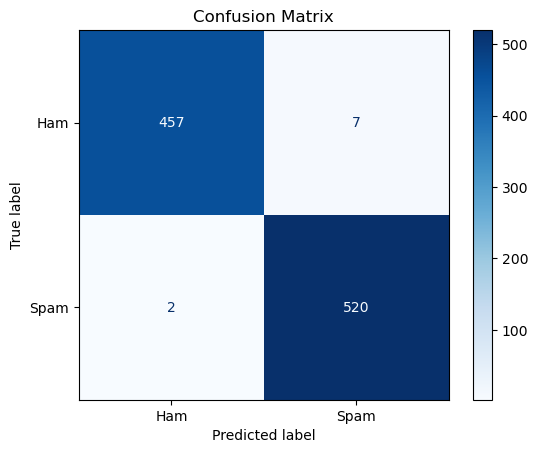

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       464
           1       0.99      1.00      0.99       522

    accuracy                           0.99       986
   macro avg       0.99      0.99      0.99       986
weighted avg       0.99      0.99      0.99       986



In [48]:
# Evaluation du modèle
predictions = model_GRU_dataaugm.predict(X_test_spams)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test_spams, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test_spams, y_pred))

In [50]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          ),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          )
])
fig.update_layout(
    title='GRU Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["sparse_categorical_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          ),
                      go.Scatter(
                          y=history.history["val_sparse_categorical_accuracy"],
                          name="Validation accuracy",
                          mode="lines",
                          )
])
fig.update_layout(
    title='GRU Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Accuracy'
)
fig.show()

In [51]:
model_GRU_dataaugm.save("./GRU1_DataAugmented.keras")

# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
print(type(history_dict))
# Save it under the form of a json file
json.dump(history_dict, open("./GRU1_DataAugmented.json", 'w'))

<class 'dict'>
